In [1]:
# Extract results

In [2]:
### Imports 
import os
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
import time
import json

import pandas as pd

sys.path.append('../../')
from script.conversion.bison.coordinates import rd_to_utm
from mnms.graph.layers import PublicTransportLayer, MultiLayerGraph, OriginDestinationLayer, SharedVehicleLayer
from mnms.generation.roads import generate_pt_line_road, generate_one_zone
from mnms.generation.layers import generate_layer_from_roads
from mnms.vehicles.veh_type import Tram, Metro, Bus, Bike
from mnms.generation.zones import generate_one_zone
from mnms.mobility_service.public_transport import PublicTransportMobilityService
from mnms.mobility_service.vehicle_sharing import VehicleSharingMobilityService
from mnms.time import TimeTable, Dt, Time
from mnms.io.graph import load_graph, save_graph, load_odlayer, save_transit_links
from mnms.tools.render import draw_roads, draw_line, draw_odlayer, draw_path, draw_veh_activity
#from mnms.tools.geometry import points_in_polygon, get_bounding_box
from mnms.time import Time

/Users/louis/opt/anaconda3/envs/mnms/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
### Parameters

# Files and directories
f = open('params.json')
params = json.load(f)

current_dir = os.getcwd()
indir = current_dir + '/inputs/'
outdir = current_dir + '/outputs/'

#coord_csv_filepath = indir + 'KV1_GVB_2609_2/Csv/POINT.csv' # file with coordinates of the network
#amsterdam_json_filepath = indir + 'new_network.json' # mlgraph with the road network only
#amsterdam_json_filepath_pt_transit = indir + "network_pt_transit.json"
#transit_path = indir + "transit.json"

FIG_SIZE_HALF = (6,3)
FONT_SIZE_LAB = 14
FONT_SIZE_LEG = 12
FONT_SIZE_AXI = 12

DIST_FAR_PT = 1000

REF_X = 632e3
REF_Y = 5.8065e6

In [4]:
### Load network

mmgraph_pt = load_graph(indir + params["fn_network"])
df_stations = pd.read_csv(indir+params['fn_emoped_st_init'])

#df_emoped1 = pd.read_csv(indir + 'init_pos_emoped.csv')
#df_emoped2 = pd.read_csv(indir + 'init_pos_emoped.csv')

### Load demand

df_dmd = pd.read_csv(indir + params['fn_demand'], sep=";")

### Load odlayer
odlayer = load_odlayer(indir + params["fn_odlayer"])
x_od = []
y_od = []
for i in odlayer.origins.items():
    x = i[1][0]
    y = i[1][1]
    x_od.append(x)
    y_od.append(y)

In [5]:
## Load results

df_emoped1_notax = pd.read_csv(outdir+'notax/emoped1_veh.csv', sep=";")
df_path_notax = pd.read_csv(outdir+'notax/path.csv', sep=";")
df_users_notax = pd.read_csv(outdir+'notax/users.csv', sep=";")
df_flow_notax = pd.read_csv(outdir+'notax/flow.csv', sep=";")

df_emoped1_tax = pd.read_csv(outdir+'tax/emoped1_veh.csv', sep=";")
df_path_tax = pd.read_csv(outdir+'tax/path.csv', sep=";")
df_users_tax = pd.read_csv(outdir+'tax/users.csv', sep=";")

df_emoped1_subsidy = pd.read_csv(outdir+'subsidy/emoped1_veh.csv', sep=";")
df_path_subsidy = pd.read_csv(outdir+'subsidy/path.csv', sep=";")
df_users_subsidy = pd.read_csv(outdir+'subsidy/users.csv', sep=";")
df_flow_subsidy = pd.read_csv(outdir+'subsidy/flow.csv', sep=";")

df_emoped1_subsidytax = pd.read_csv(outdir+'subsidytax/emoped1_veh.csv', sep=";")
df_path_subsidytax = pd.read_csv(outdir+'subsidytax/path.csv', sep=";")
df_users_subsidytax = pd.read_csv(outdir+'subsidytax/users.csv', sep=";")

#df_emoped1_noemoped = pd.read_csv(outdir+'noemoped/emoped1_veh.csv', sep=";")
df_path_noemoped = pd.read_csv(outdir+'noemoped/path.csv', sep=";")
df_users_noemoped = pd.read_csv(outdir+'noemoped/users.csv', sep=";")

#df_emoped1_tax = pd.read_csv(outdir+'notax/emoped1_veh.csv', sep=";")
#df_path_tax = pd.read_csv(outdir+'notax/path.csv', sep=";")
#df_users_tax = pd.read_csv(outdir+'notax/users.csv', sep=";")

#df_emoped1_subsidy = pd.read_csv(outdir+'notax/emoped1_veh.csv', sep=";")
#df_path_subsidy = pd.read_csv(outdir+'notax/path.csv', sep=";")
#df_users_subsidy = pd.read_csv(outdir+'notax/users.csv', sep=";")

#df_emoped1_subsidytax = pd.read_csv(outdir+'notax/emoped1_veh.csv', sep=";")
#df_path_subsidytax = pd.read_csv(outdir+'notax/path.csv', sep=";")
#df_users_subsidytax = pd.read_csv(outdir+'notax/users.csv', sep=";")

#df_path_noemoped = pd.read_csv(outdir+'notax/path.csv', sep=";")
#df_users_noemoped = pd.read_csv(outdir+'notax/users.csv', sep=";")

In [6]:
# Look vehicle trajectory
"""veh_id = 130
df = df_emoped1[df_emoped1["ID"] == int(veh_id)]
list_pos_emoped = np.zeros((len(df['POSITION']),2))
for i, row in enumerate(df['POSITION']):
    pos = row.split(' ')
    #plt.text(float(pos[0]), float(pos[1]), row.TIME)
    list_pos_emoped[i,:] = [float(pos[0]), float(pos[1])]"""

'veh_id = 130\ndf = df_emoped1[df_emoped1["ID"] == int(veh_id)]\nlist_pos_emoped = np.zeros((len(df[\'POSITION\']),2))\nfor i, row in enumerate(df[\'POSITION\']):\n    pos = row.split(\' \')\n    #plt.text(float(pos[0]), float(pos[1]), row.TIME)\n    list_pos_emoped[i,:] = [float(pos[0]), float(pos[1])]'

# Demand

In [7]:
len(df_dmd)

362

In [8]:
df_dmd

,ID,DEPARTURE,ORIGIN,DESTINATION
0,351,16:00:12,628728.7017783116 5807983.9836506555,631751.990023734 5806822.694018583
1,99,16:00:28,627057.7451733527 5800165.063470718,632033.0129260347 5806070.753100674
2,41,16:00:41,632431.5859577961 5803428.88492705,632074.9445384147 5806903.538974105
3,146,16:00:43,632355.9912842601 5806151.594191469,629281.134139592 5802092.283868504
4,229,16:01:36,628639.8575553824 5804125.078511461,631751.990023734 5806822.694018583
...,...,...,...,...
357,256,17:57:47,632477.6230067669 5806456.149086589,632830.2888282188 5800786.005179767
358,106,17:58:08,628148.3690768027 5800712.077191639,631630.356380139 5806518.162981593
359,261,17:59:12,632477.6230067669 5806456.149086589,630539.8818980164 5805971.116783773
360,340,17:59:45,632842.496763694 5807369.765771839,632074.9445384147 5806903.538974105


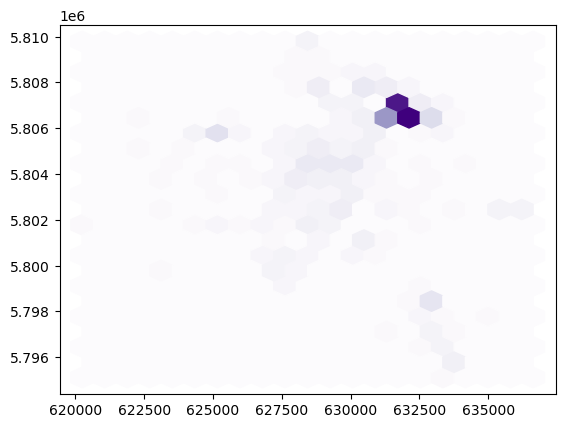

In [9]:
origin_points = np.asarray([[float(x) for x in s.split(' ')] for s in df_dmd.ORIGIN.values])
plt.hexbin(origin_points[:,0],origin_points[:,1], gridsize=20, cmap='Purples')

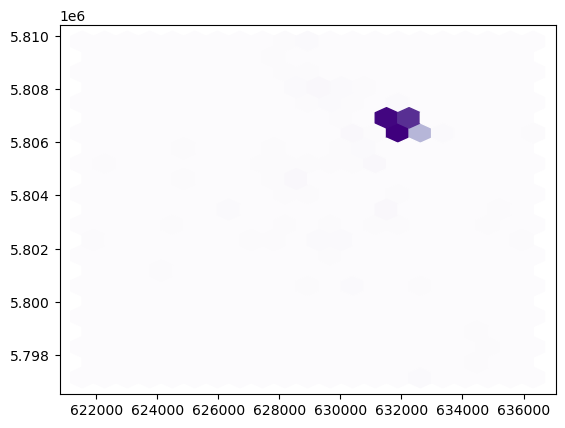

In [10]:
destination_points = np.asarray([[float(x) for x in s.split(' ')] for s in df_dmd.DESTINATION.values])
plt.hexbin(destination_points[:,0],destination_points[:,1], gridsize=20, cmap='Purples')

In [11]:
mmgraph_pt = load_graph(params["indir"] + params["fn_network"])
position_stations = []
for key in mmgraph_pt.roads.stops.keys():
    if 'METRO' in key or 'TRAM' in key:
        position_stations.append(mmgraph_pt.roads.stops[key].absolute_position)

dist_o = []
for o in origin_points:
    distances = [(o[0]-s[0])**2+(o[1]-s[1])**2 for s in position_stations]
    dist_o.append(np.sqrt(min(distances)))
dist_d = []
for d in destination_points:
    distances = [(d[0]-s[0])**2+(d[1]-s[1])**2 for s in position_stations]
    dist_d.append(np.sqrt(min(distances)))

In [12]:
df_dmd['DIST_STA_ORIG'] = dist_o
df_dmd['DIST_STA_DEST'] = dist_d

In [13]:
mask = (df_dmd.DIST_STA_ORIG>=DIST_FAR_PT) | (df_dmd.DIST_STA_DEST>=DIST_FAR_PT)

In [14]:
df_dmd_far = df_dmd[mask]

In [15]:
sum(mask)

138

In [16]:
df_dmd_far

,ID,DEPARTURE,ORIGIN,DESTINATION,DIST_STA_ORIG,DIST_STA_DEST
0,351,16:00:12,628728.7017783116 5807983.9836506555,631751.990023734 5806822.694018583,2679.722597,695.644645
1,99,16:00:28,627057.7451733527 5800165.063470718,632033.0129260347 5806070.753100674,210.979889,1391.966877
3,146,16:00:43,632355.9912842601 5806151.594191469,629281.134139592 5802092.283868504,1540.905287,197.956908
8,2,16:02:24,625215.0373941862 5805734.339360864,632355.9912842601 5806151.594191469,99.890809,1540.905287
10,161,16:02:45,632922.2308749937 5806841.544311372,631751.990023734 5806822.694018583,1639.976167,695.644645
...,...,...,...,...,...,...
338,150,17:51:17,632355.9912842601 5806151.594191469,631227.739290507 5806965.527898926,1540.905287,475.262096
339,13,17:51:28,625659.5136546462 5806119.602280895,632355.9912842601 5806151.594191469,539.149898,1540.905287
357,256,17:57:47,632477.6230067669 5806456.149086589,632830.2888282188 5800786.005179767,1452.681279,216.747425
359,261,17:59:12,632477.6230067669 5806456.149086589,630539.8818980164 5805971.116783773,1452.681279,29.204823


In [17]:
def calc_dist(row):
    pos1 = [float(x) for x in row.ORIGIN.split(' ')]
    pos2 = [float(x) for x in row.DESTINATION.split(' ')]
    #dist = abs(pos1[0]-pos2[0]) + abs(pos1[1]-pos2[1])
    dist = ((pos1[0]-pos2[0])**2 + (pos1[1]-pos2[1])**2)**0.5
    return dist

dist = df_dmd.apply(calc_dist, axis=1)

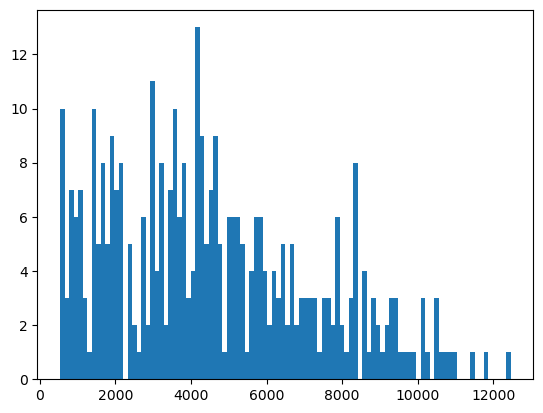

In [18]:
plt.hist(dist, bins=100);

In [19]:
# Look O/D for users wihtout paths
list_nomatch = []
list_origins = []
list_destinations = []
for i, row in df_path_notax[:].iterrows():
    if pd.isna(row['PATH']):
        list_nomatch.append(row['ID'])
        user = df_dmd[df_dmd['ID']==row['ID']]
        list_origins.append([float(o) for o in user['ORIGIN'].iloc[0].split(' ')])
        list_destinations.append([float(o) for o in user['DESTINATION'].iloc[0].split(' ')])

In [20]:
"""id_user = '1066750-1'
o_user =  [float(o) for o in df_dmd[df_dmd['ID']==id_user]['ORIGIN'].iloc[0].split(' ')]
d_user =  [float(o) for o in df_dmd[df_dmd['ID']==id_user]['DESTINATION'].iloc[0].split(' ')]

dist_o = [(o_user[0]-x)**2 + (o_user[1]-y)**2 for (x,y) in zip(x_od,y_od)]
dist_d = [(d_user[0]-x)**2 + (d_user[1]-y)**2 for (x,y) in zip(x_od,y_od)]
print(np.argmin(dist_o), np.argmin(dist_d))"""

"id_user = '1066750-1'\no_user =  [float(o) for o in df_dmd[df_dmd['ID']==id_user]['ORIGIN'].iloc[0].split(' ')]\nd_user =  [float(o) for o in df_dmd[df_dmd['ID']==id_user]['DESTINATION'].iloc[0].split(' ')]\n\ndist_o = [(o_user[0]-x)**2 + (o_user[1]-y)**2 for (x,y) in zip(x_od,y_od)]\ndist_d = [(d_user[0]-x)**2 + (d_user[1]-y)**2 for (x,y) in zip(x_od,y_od)]\nprint(np.argmin(dist_o), np.argmin(dist_d))"

# Plot network

In [21]:
polygon = np.asarray(params['polygon_demand'])

In [22]:
x_st = []
y_st = []
for n in df_stations['closest_node']:
    x_st.append(mmgraph_pt.roads.nodes[n].position[0])
    y_st.append(mmgraph_pt.roads.nodes[n].position[1])

In [23]:
x_nodes = []
y_nodes = []
for key in mmgraph_pt.roads.nodes.keys():
    pos = mmgraph_pt.roads.nodes[key].position
    x_nodes.append(pos[0])
    y_nodes.append(pos[1])

In [24]:
print([p - polygon[0,0] for p in polygon[:,0]])
print([p - polygon[0,1] for p in polygon[:,1]])

[0.0, 23000.0, 23000.0, 0.0]
[0.0, 0.0, -20000.0, -20000.0]


(5793000.0, 5813000.0)

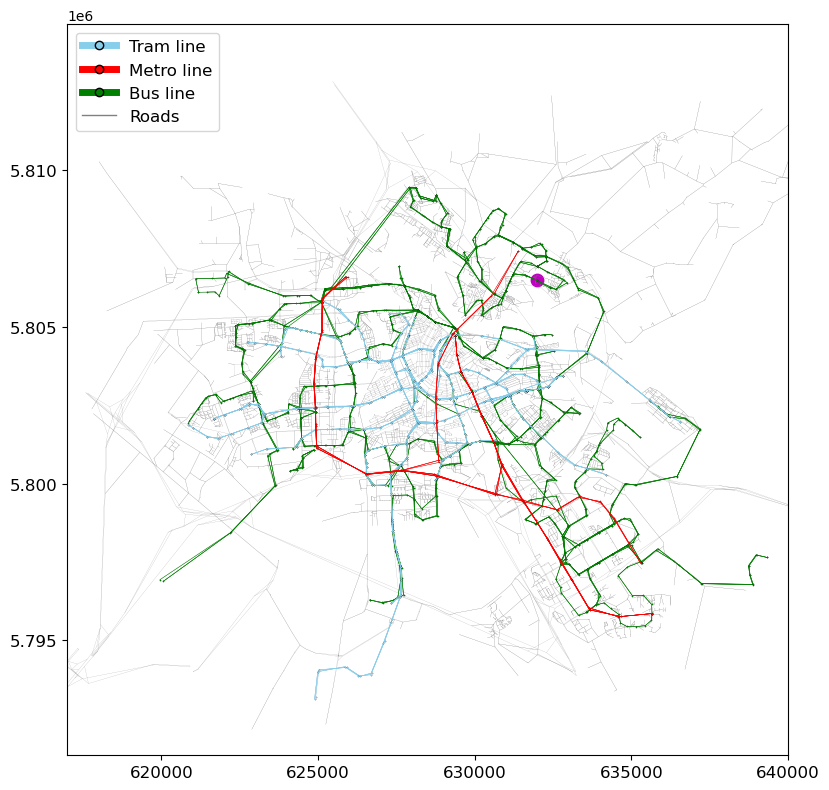

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))

draw_roads(ax, mmgraph_pt.roads, color='grey', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)

# Params of the visualization
colors = {'BUS': 'green', 'METRO': 'red', 'TRAM': 'skyblue'}

for layer in mmgraph_pt.layers.values():
    if type(layer) == PublicTransportLayer:
        for name, line in layer.lines.items():
                draw_line(ax, mmgraph_pt, line, color=colors[name[:name.find('_')]], 
                          linkwidth=0.4, nodesize=1, line_label=None, label_size=1, alpha=1., stopmarkeredgewidth=0.1)

#plt.plot(x_od, y_od, 'dk', alpha=0.4)

#plt.plot(x_st, y_st, '*b')

#plt.plot(x_nodes, y_nodes, '.m', alpha=0.5, markersize=1)

#plt.plot(list_pos_emoped[:,0], list_pos_emoped[:,1], ':.')

for o,d in zip(list_origins, list_destinations):
    plt.plot([o[0], d[0]], [o[1], d[1]], 'm:', alpha=0.2)
    plt.plot(d[0], d[1], 'dm', alpha=0.2)
    plt.plot(o[0], o[1], 'om', alpha=0.2)

#plt.plot([o_user[0], d_user[0]], [o_user[1], d_user[1]], 'o-')
x=list(polygon[:,0])
x.append(polygon[0,0])
y=list(polygon[:,1])
y.append(polygon[0,1])
#plt.plot(x, y, '+--k')

legend = [Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='skyblue', linewidth=5,
            label='Tram line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='red', linewidth=5,
            label='Metro line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=12, markeredgecolor='black', color='green', linewidth=5,
            label='Bus line'),
          Line2D([0, 1], [0, 1], marker='.', markersize=0, markeredgecolor='grey', markerfacecolor='grey', color='grey', linewidth=1,
            label='Roads')]
#          Line2D([0, 1], [0, 1], marker='*', markersize=10, color='b', linewidth=0,
#            label='Virtual station')]

#plt.hexbin(destination_points[:,0],destination_points[:,1], gridsize=20, cmap='Purples')
#plt.hexbin(origin_points[:,0],origin_points[:,1], gridsize=20, cmap='Greens')


plt.scatter(REF_X, REF_Y, marker='o', s=80, color='m')

legend = plt.legend(handles=legend, fontsize=FONT_SIZE_LEG)
plt.tight_layout() 
#plt.legend(, ncol=2, loc='lower left', bbox_to_anchor=(0.1,1),)
plt.xticks(fontsize=FONT_SIZE_AXI)
plt.yticks(fontsize=FONT_SIZE_AXI)
plt.xlim([617000,640000])
plt.ylim([5.793e6, 5.813e6])
#plt.savefig(params['figdir']+'network_light_smallcase.pdf', bbox_inches = 'tight')


## Modes shares

In [26]:
def emoped_in_modes(modes):
    if pd.isna(modes):
        return False
    else:
        return 'emoped1' in modes

def pt_in_modes(modes):
    if pd.isna(modes):
        return False
    else:
        return ('BUS' in modes) or ('TRAM' in modes) or ('METRO' in modes)

def bus_in_modes(modes):
    if pd.isna(modes):
        return False
    else:
        return ('BUS' in modes)

def tram_in_modes(modes):
    if pd.isna(modes):
        return False
    else:
        return ('TRAM' in modes)

def metro_in_modes(modes):
    if pd.isna(modes):
        return False
    else:
        return ('METRO' in modes)

def calculate_mode_shares(df_paths, list_id):
    emoped_only = 0
    pt_only = 0
    combined = 0
    walk = 0
    no_match = 0
    for id in list_id[:]:
        paths = df_paths[df_paths['ID']==id]
        path = paths.iloc[-1]
        modes = path['SERVICES']
        if emoped_in_modes(modes):
            if pt_in_modes(modes):
                combined+=1
                #print(id)
            if (not pt_in_modes(modes)):
                emoped_only+=1
        elif pt_in_modes(modes):
            pt_only+=1
        elif pd.isna(modes):
            no_match+=1
        else:
            walk += 1
    sum = len(list_id)
    return (np.around(emoped_only/sum,3), np.around(pt_only/sum,3), np.around(combined/sum,3), np.around(walk/sum,3), np.around(no_match/sum,3))

def calculate_pt_shares(df_paths, list_id):
    bus = 0
    tram = 0
    metro = 0
    for id in list_id[:]:
        paths = df_paths[df_paths['ID']==id]
        path = paths.iloc[-1]
        #path = paths.iloc[0]
        modes = path['SERVICES']
        if bus_in_modes(modes):
            bus += 1
        if tram_in_modes(modes):
            tram += 1
        if metro_in_modes(modes):
            metro += 1
    sum = len(list_id)
    return (np.around(bus/sum,3), np.around(tram/sum,3), np.around(metro/sum,3))
    

In [27]:
list_id = df_dmd['ID'].unique()
shares_notax = calculate_mode_shares(df_path_notax, list_id)
shares_tax = calculate_mode_shares(df_path_tax, list_id)
shares_subsidy = calculate_mode_shares(df_path_subsidy, list_id)
shares_subsidytax = calculate_mode_shares(df_path_subsidytax, list_id)
shares_noemoped = calculate_mode_shares(df_path_noemoped, list_id)

In [28]:
print('notax-----', shares_notax)
print('tax-------', shares_tax)
print('subsidy---', shares_subsidy)
print('subsidytax', shares_subsidytax)
print('noemoped--', shares_noemoped)

notax----- (0.061, 0.843, 0.022, 0.075, 0.0)
tax------- (0.047, 0.84, 0.036, 0.077, 0.0)
subsidy--- (0.05, 0.818, 0.033, 0.099, 0.0)
subsidytax (0.025, 0.829, 0.058, 0.088, 0.0)
noemoped-- (0.0, 0.983, 0.0, 0.017, 0.0)


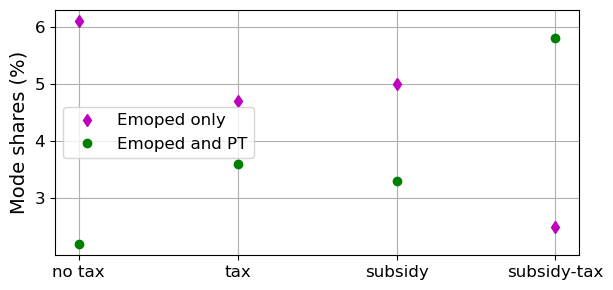

In [29]:
shares = [shares_notax, shares_tax, shares_subsidy, shares_subsidytax]
plt.figure(figsize=FIG_SIZE_HALF)
plt.plot(np.arange(4), [s[0]*100 for s in shares], 'md')
plt.plot(np.arange(4), [s[2]*100 for s in shares], 'go')
plt.xticks(ticks=np.arange(4), labels=('no tax', 'tax', 'subsidy', 'subsidy-tax'), fontsize=FONT_SIZE_AXI)
plt.tight_layout() 
plt.grid()
plt.yticks(fontsize=FONT_SIZE_AXI)
plt.ylabel('Mode shares (%)', fontsize=FONT_SIZE_LAB)
legend = [Line2D([0,0.1], [0,0.1], marker='d', color='m',
            label='Emoped only', linewidth=0),
          Line2D([0,0.1], [0,0.1], marker='o', color='g',
            label='Emoped and PT', linewidth=0)]
legend = plt.legend(handles=legend, fontsize=FONT_SIZE_LEG)#, loc=(0.1,0.3))
#plt.savefig(params['figdir']+'shares_smallcase.pdf', bbox_inches = 'tight')

In [30]:
list_id_far = df_dmd_far['ID'].unique()

print('notax-----', calculate_mode_shares(df_path_notax, list_id_far))
print('tax-------', calculate_mode_shares(df_path_tax, list_id_far))
print('subsidy---', calculate_mode_shares(df_path_subsidy, list_id_far))
print('subsidytax', calculate_mode_shares(df_path_subsidytax, list_id_far))

## 

print('notax', calculate_pt_shares(df_path_notax, list_id_far))
print('subsidytax', calculate_pt_shares(df_path_subsidytax, list_id_far))

notax----- (0.138, 0.725, 0.043, 0.094, 0.0)
tax------- (0.109, 0.717, 0.072, 0.101, 0.0)
subsidy--- (0.109, 0.681, 0.051, 0.159, 0.0)
subsidytax (0.051, 0.703, 0.116, 0.13, 0.0)
notax (0.681, 0.283, 0.362)
subsidytax (0.739, 0.254, 0.333)


In [31]:
df_path_notax.CHOSEN.unique()

array([1])

In [32]:
sum(df_path_notax[df_path_notax.EVENT=='MATCH_FAILURE'].CHOSEN!=1)/6000

0.0

In [33]:
df_path = df_path_notax

list_ser=[]
pt_before = []
pt_after = []
pt_before_after = []
for service, i_user in zip(df_path.SERVICES, df_path.ID):
    if pd.isna(service): 
        service = ''
    ser = service.replace('WALK','')
    ser = ser.replace(' ','')
    if emoped_in_modes(ser) and pt_in_modes(ser):
        a = ser.split('emoped1')
        if len(a[0])>0 and len(a[-1])>0:
            pt_before_after.append(i_user)
        elif len(a[0])>0:
            pt_before.append(i_user)
        elif len(a[-1])>0:
            pt_after.append(i_user)

In [34]:
o_pt_before = []
d_pt_before = []
df = df_dmd.set_index('ID')
for i_user in pt_before:
    user = df.loc[i_user]
    o_pt_before.append([float(o) for o in user['ORIGIN'].split(' ')])
    d_pt_before.append([float(o) for o in user['DESTINATION'].split(' ')])
o_pt_before = np.asarray(o_pt_before)
d_pt_before = np.asarray(d_pt_before)

o_pt_after = []
d_pt_after = []
for i_user in pt_after:
    user = df.loc[i_user]
    o_pt_after.append([float(o) for o in user['ORIGIN'].split(' ')])
    d_pt_after.append([float(o) for o in user['DESTINATION'].split(' ')])
o_pt_after = np.asarray(o_pt_after)
d_pt_after = np.asarray(d_pt_after)

In [35]:
print(pt_before, pt_after, pt_before_after)

[99, 199, 220, 227, 3] [266, 268, 192] [259, 262, 255]


## TTT/TTD

In [36]:
def calculate_tt_td(list_id, df_users):
    tt = []
    td = []
    #count = 0
    for id in list_id:
        df = df_users[df_users['ID']==id]
        if len(df)>1:
            tt.append(Time(df['TIME'].iloc[-1]).to_seconds()/60 - Time(df['TIME'].iloc[0]).to_seconds()/60)
            td.append(df['DISTANCE'].iloc[-1])
            #count += 1
    return (tt, td)

In [37]:
# Compute total travel time/distance

tt_notax, td_notax = calculate_tt_td(list_id, df_users_notax)
tt_tax, td_tax = calculate_tt_td(list_id, df_users_tax)
tt_subsidy, td_subsidy = calculate_tt_td(list_id, df_users_subsidy)
tt_subsidytax, td_subsidytax = calculate_tt_td(list_id, df_users_subsidytax)
tt_noemoped, td_noemoped = calculate_tt_td(list_id, df_users_noemoped)

tt_notax_far, td_notax_far = calculate_tt_td(list_id_far, df_users_notax)
tt_tax_far, td_tax_far = calculate_tt_td(list_id_far, df_users_tax)
tt_subsidy_far, td_subsidy_far = calculate_tt_td(list_id_far, df_users_subsidy)
tt_subsidytax_far, td_subsidytax_far = calculate_tt_td(list_id_far, df_users_subsidytax)

In [38]:
#plt.hist(tt_notax, alpha=0.5, label = "notax", bins=100, density=True, cumulative=True);
#plt.hist(tt_tax, alpha=0.5, label = "tax", bins=100, density=True, cumulative=True);
#plt.hist(tt_subsidy, alpha=0.5, label = "subsidy", bins=100, density=True, cumulative=True);
#plt.hist(tt_subsidytax, alpha=0.5, label = "subsidytax", bins=100, density=True, cumulative=True);
#plt.legend()

In [39]:
#plt.hist(tt_notax_far, alpha=0.5, label = "notax", bins=100, density=True, cumulative=True);
#plt.hist(tt_tax_far, alpha=0.5, label = "tax", bins=100, density=True, cumulative=True);
#plt.hist(tt_subsidy_far, alpha=0.5, label = "subsidy", bins=100, density=True, cumulative=True);
#plt.hist(tt_subsidytax_far, alpha=0.5, label = "subsidytax", bins=100, density=True, cumulative=True);
#plt.legend()

In [40]:
print(np.mean(tt_notax_far), np.std(tt_notax_far))
print(np.mean(tt_tax_far), np.std(tt_tax_far))
print(np.mean(tt_subsidy_far), np.std(tt_subsidy_far))
print(np.mean(tt_subsidytax_far), np.std(tt_subsidytax_far))


33.9000724637681 16.763532705131727
33.9595531400966 16.76811043586504
34.66018236714975 16.66298346039762
34.861143719806755 16.363934982810687


In [41]:
print(np.mean(tt_notax), np.std(tt_notax))
print(np.mean(tt_tax), np.std(tt_tax))
print(np.mean(tt_subsidy), np.std(tt_subsidy))
print(np.mean(tt_subsidytax), np.std(tt_subsidytax))
print(np.mean(tt_noemoped), np.std(tt_noemoped))
print((np.mean(tt_noemoped)-np.mean(tt_notax))/np.mean(tt_noemoped))

35.87247651933701 15.106310044290154
35.91730340699816 15.100904956527849
36.18434162062615 15.038100264316324
36.27757826887661 14.880230060842816
37.608215469613256 14.723971127707507
0.04615318564313928


Text(41.972222222222214, 0.5, 'Travel times (min)')

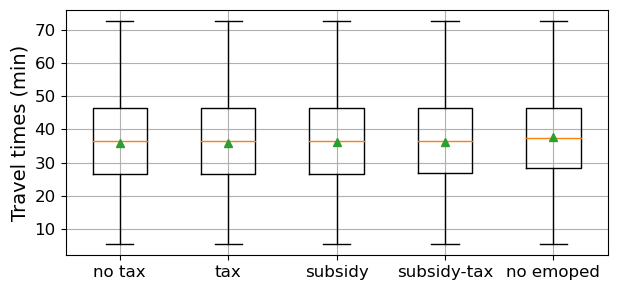

In [42]:
plt.figure(figsize=FIG_SIZE_HALF)
#plt.plot([0], np.mean(tt_notax)/60, 'md')
plt.boxplot([tt_notax, tt_tax, tt_subsidy, tt_subsidytax, tt_noemoped] ,
            positions=np.arange(5), showfliers=False, showmeans=True)
plt.xticks(ticks=np.arange(5), labels=('no tax', 'tax', 'subsidy', 'subsidy-tax', 'no emoped'), fontsize=FONT_SIZE_AXI)
plt.tight_layout() 
plt.grid()
plt.yticks(fontsize=FONT_SIZE_AXI)
#plt.xlabel('Distance (km)', fontsize=FONT_SIZE_LAB)
plt.ylabel('Travel times (min)', fontsize=FONT_SIZE_LAB)
#plt.savefig(params['figdir']+'dist_ttimes.pdf', bbox_inches = 'tight')

## Emoped usage

In [43]:
def calculate_emoped_indicators(df_emoped):
    list_emoped = df_emoped['ID'].unique()
    distances = []
    TTD = 0
    TTT = 0
    nb_rides = 0
    for id in list_emoped:
        df = df_emoped[df_emoped['ID']==id]
        TTD += df['DISTANCE'].iloc[-1]
        
        nb_rides_loc = sum(df.STATE=='STOP')-1
        #nb_rides += nb_rides_loc
        i_stops = np.where(df.STATE=='STOP')[0]
        for i in range(nb_rides_loc):
            i_start = i_stops[i]
            i_start_tt = i_stops[i]+1
            i_stop = i_stops[i+1]
            if i_start+1==i_stop:
                pass 
                #print(id)
            else:
                TTT += str_to_time(df.TIME.iloc[i_stop]) - str_to_time(df.TIME.iloc[i_start_tt])
                distances.append(df.DISTANCE.iloc[i_stop] - df.DISTANCE.iloc[i_start])
                nb_rides += 1
                if (df.DISTANCE.iloc[i_stop] - df.DISTANCE.iloc[i_start])<100:
                    print(id, i_stops)
    return (TTD*1e-3, TTT/3600, nb_rides, distances)

def str_to_time(time_str):
    return sum([float(t)*60**(2-i) for i,t in enumerate(time_str.split(':'))])

In [44]:
ttd_notax, ttt_notax, nb_rides_notax, dist_notax = calculate_emoped_indicators(df_emoped1_notax)
ttd_tax, ttt_tax, nb_rides_tax, dist_tax = calculate_emoped_indicators(df_emoped1_tax)
ttd_subsidy, ttt_subsidy, nb_rides_subsidy, dist_subsidy = calculate_emoped_indicators(df_emoped1_subsidy)
ttd_subsidytax, ttt_subsidytax, nb_rides_subsidytax, dist_subsidytax = calculate_emoped_indicators(df_emoped1_subsidytax)

In [45]:
print(sum(np.asarray(dist)==0))
print(ttd_notax/ttt_notax, 'km/h')

0
30.322444 km/h


In [46]:
rev_notax = 1*nb_rides_notax + 0.33*ttt_notax*60
rev_tax = 1*nb_rides_tax + 0.33*ttt_tax*60
rev_subsidy = 1*nb_rides_subsidy + 0.33*ttt_subsidy*60
rev_subsidytax = 1*nb_rides_subsidytax + 0.33*ttt_subsidytax*60

In [47]:
print(ttd_notax, ttt_notax, nb_rides_notax, rev_notax)
print(ttd_tax, ttt_tax, nb_rides_tax, rev_tax)
print(ttd_subsidy, ttt_subsidy, nb_rides_subsidy, rev_subsidy)
print(ttd_subsidytax, ttt_subsidytax, nb_rides_subsidytax, rev_subsidytax)

print((nb_rides_tax-nb_rides_notax)/nb_rides_notax, (rev_tax-rev_notax)/rev_notax)
print((nb_rides_subsidy-nb_rides_notax)/nb_rides_notax, (rev_subsidy-rev_notax)/rev_notax)
print((nb_rides_subsidytax-nb_rides_notax)/nb_rides_notax, (rev_subsidytax-rev_notax)/rev_notax)

75.80611 2.5 26 75.5
73.44536000000002 2.433333333333333 25 73.17999999999999
71.95374200000002 2.433333333333333 29 77.17999999999999
67.43191100000003 2.2333333333333334 26 70.22
-0.038461538461538464 -0.03072847682119215
0.11538461538461539 0.022251655629138976
0.0 -0.0699337748344371


In [48]:
print(ttd_notax/nb_rides_notax)
print(ttd_tax/nb_rides_tax)
print(ttd_subsidy/nb_rides_subsidy)
print(ttd_subsidytax/nb_rides_subsidytax)

2.9156196153846157
2.937814400000001
2.48116351724138
2.5935350384615394


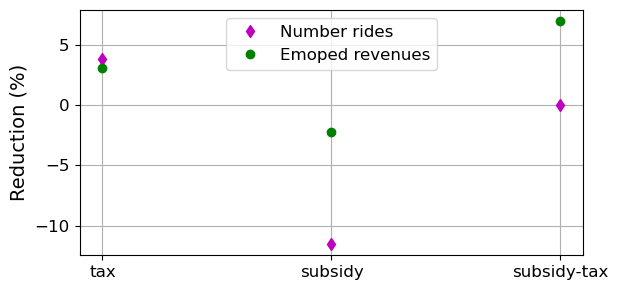

In [49]:
prop_rides = [-100*(nb_rides_tax-nb_rides_notax)/nb_rides_notax,
              -100*(nb_rides_subsidy-nb_rides_notax)/nb_rides_notax,
              -100*(nb_rides_subsidytax-nb_rides_notax)/nb_rides_notax]
prop_rev = [-100*(rev_tax-rev_notax)/rev_notax, -100*(rev_subsidy-rev_notax)/rev_notax, -100*(rev_subsidytax-rev_notax)/rev_notax]
plt.figure(figsize=FIG_SIZE_HALF)
plt.plot(np.arange(3), prop_rides, 'md')
plt.plot(np.arange(3), prop_rev, 'go')
plt.xticks(ticks=np.arange(3), labels=('tax', 'subsidy', 'subsidy-tax'), fontsize=FONT_SIZE_AXI)
plt.tight_layout() 
plt.grid()
plt.yticks(fontsize=FONT_SIZE_AXI)
plt.ylabel('Reduction (%)', fontsize=FONT_SIZE_LAB)
legend = [Line2D([0,0.1], [0,0.1], marker='d', color='m',
            label='Number rides', linewidth=0),
          Line2D([0,0.1], [0,0.1], marker='o', color='g',
            label='Emoped revenues', linewidth=0)]
legend = plt.legend(handles=legend, fontsize=FONT_SIZE_LEG)
#plt.savefig(params['figdir']+'rides_rev_smallcase.pdf', bbox_inches = 'tight')

Text(42.597222222222214, 0.5, 'Cumulative density')

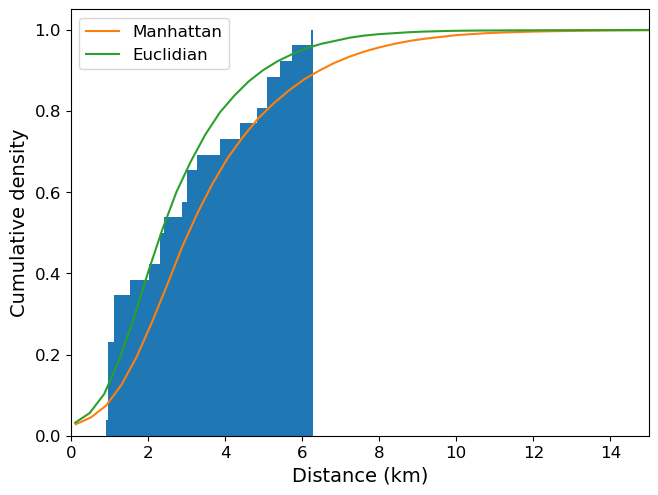

In [50]:
# Calibration
df_dist_mhtn = pd.read_csv('inputs/processed_felyx_data/df_dist_mhtn.csv')
df_dist_eucl = pd.read_csv('inputs/processed_felyx_data/df_dist_eucl.csv')

plt.hist(np.asarray(dist_notax)*1e-3, bins=100, cumulative=True, density=True);
plt.plot(df_dist_mhtn.dist*1e-3, df_dist_mhtn.dsty, label='Manhattan')
plt.plot(df_dist_eucl.dist*1e-3, df_dist_eucl.dsty, label='Euclidian')
plt.legend(fontsize=FONT_SIZE_LEG)
plt.xlim([0,15])
plt.tight_layout() 
#plt.legend(, ncol=2, loc='lower left', bbox_to_anchor=(0.1,1),)
plt.xticks(fontsize=FONT_SIZE_AXI)
plt.yticks(fontsize=FONT_SIZE_AXI)
plt.xlabel('Distance (km)', fontsize=FONT_SIZE_LAB)
plt.ylabel('Cumulative density', fontsize=FONT_SIZE_LAB)
#plt.savefig(params['figdir']+'dist_distribution.pdf', bbox_inches = 'tight')

In [51]:
df_emoped1_notax

,TIME,ID,TYPE,LINK,POSITION,SPEED,STATE,DISTANCE,PASSENGERS
0,15:59:00.00,29,Bike,NaN,631961.476 5806587.548,5.5,STOP,0.000,NaN
1,15:59:00.00,28,Bike,NaN,631961.476 5806587.548,5.5,STOP,0.000,NaN
2,15:59:00.00,27,Bike,NaN,631961.476 5806587.548,5.5,STOP,0.000,NaN
3,15:59:00.00,26,Bike,NaN,631961.476 5806587.548,5.5,STOP,0.000,NaN
4,15:59:00.00,25,Bike,NaN,631961.476 5806587.548,5.5,STOP,0.000,NaN
...,...,...,...,...,...,...,...,...,...
130,16:59:00.00,21,Bike,EMOPEDLayer1_m2001320486 EMOPEDLayer1_m46559817,628218.256 5809183.065,7.0,SERVING,5880.000,295.0
131,16:59:00.00,27,Bike,EMOPEDLayer1_m46565157 EMOPEDLayer1_m46564636,629424.376 5809430.475,7.0,SERVING,4200.000,296.0
132,17:01:00.00,21,Bike,EMOPEDLayer1_m46558003 EMOPEDLayer1_m46558066,628043.612 5809163.911,7.0,STOP,6287.566,NaN
133,17:01:00.00,27,Bike,EMOPEDLayer1_m46564636 EMOPEDLayer1_m46555017,628829.449 5809122.592,7.0,SERVING,5040.000,296.0


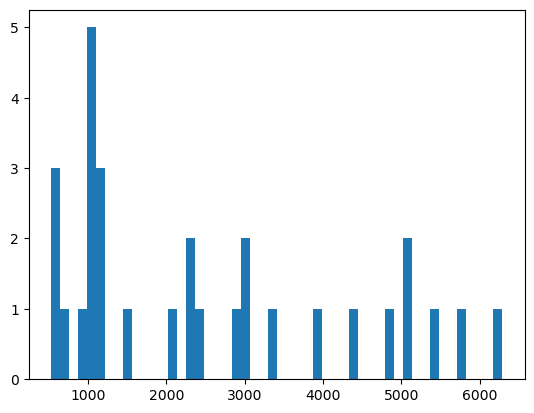

In [52]:
list_emoped = df_emoped1_notax['ID'].unique()
d = []
pos = []
for id in list_emoped:
    df = df_emoped1_notax[df_emoped1_notax['ID']==id]
    d.append(df['DISTANCE'].iloc[-1])
    if df['DISTANCE'].iloc[-1]==0:
        pos.append([float(x) for x in df.POSITION.iloc[-1].split(' ')])
plt.hist(d, bins=50);
pos = np.array(pos)

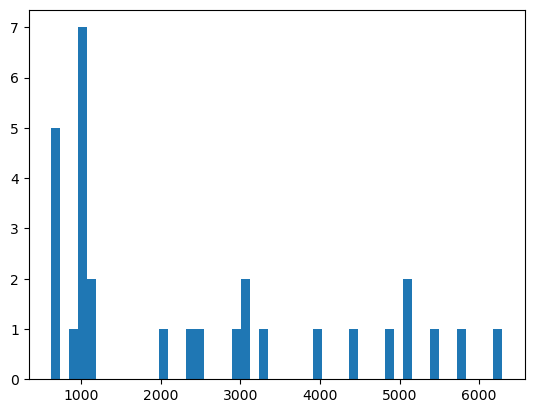

In [53]:
list_emoped = df_emoped1_tax['ID'].unique()
d = []
pos = []
for id in list_emoped:
    df = df_emoped1_tax[df_emoped1_tax['ID']==id]
    d.append(df['DISTANCE'].iloc[-1])
    if df['DISTANCE'].iloc[-1]==0:
        pos.append([float(x) for x in df.POSITION.iloc[-1].split(' ')])
plt.hist(d, bins=50);
pos = np.array(pos)

In [54]:
sum([d_==0 for d_ in d])

0

In [55]:
df_dmd_far

,ID,DEPARTURE,ORIGIN,DESTINATION,DIST_STA_ORIG,DIST_STA_DEST
0,351,16:00:12,628728.7017783116 5807983.9836506555,631751.990023734 5806822.694018583,2679.722597,695.644645
1,99,16:00:28,627057.7451733527 5800165.063470718,632033.0129260347 5806070.753100674,210.979889,1391.966877
3,146,16:00:43,632355.9912842601 5806151.594191469,629281.134139592 5802092.283868504,1540.905287,197.956908
8,2,16:02:24,625215.0373941862 5805734.339360864,632355.9912842601 5806151.594191469,99.890809,1540.905287
10,161,16:02:45,632922.2308749937 5806841.544311372,631751.990023734 5806822.694018583,1639.976167,695.644645
...,...,...,...,...,...,...
338,150,17:51:17,632355.9912842601 5806151.594191469,631227.739290507 5806965.527898926,1540.905287,475.262096
339,13,17:51:28,625659.5136546462 5806119.602280895,632355.9912842601 5806151.594191469,539.149898,1540.905287
357,256,17:57:47,632477.6230067669 5806456.149086589,632830.2888282188 5800786.005179767,1452.681279,216.747425
359,261,17:59:12,632477.6230067669 5806456.149086589,630539.8818980164 5805971.116783773,1452.681279,29.204823


In [56]:
df_path_far = df_path_notax[df_path_notax.ID.isin(list_id_far)]

In [57]:
emoped_use = df_path_far.SERVICES.apply(emoped_in_modes)
mask = (df_path_far.LENGTH>10e3) #& emoped_use

df_path_far[mask]

,ID,EVENT,TIME,COST,PATH,LENGTH,SERVICES,CHOSEN
1,99,DEPARTURE,15:59:00.00,19.156904,ORIGIN_273 TRAM_5_DIR1_TRAM_5_DIR1_8 TRAM_5_DI...,10553.003776,WALK TRAM WALK TRAM WALK METRO WALK BUS WALK e...,1
8,2,DEPARTURE,16:01:00.00,23.472422,ORIGIN_166 TRAM_19_DIR1_TRAM_19_DIR1_0 TRAM_19...,10008.215481,WALK TRAM WALK TRAM WALK TRAM WALK METRO WALK ...,1
80,3,DEPARTURE,16:23:00.00,23.080060,ORIGIN_166 TRAM_19_DIR1_TRAM_19_DIR1_0 TRAM_19...,10157.549534,WALK TRAM WALK TRAM WALK TRAM WALK METRO WALK ...,1
100,145,DEPARTURE,16:27:00.00,28.809090,ORIGIN_673 BUS_35_DIR2_BUS_35_DIR2_5 BUS_35_DI...,13779.169452,WALK BUS WALK METRO WALK TRAM WALK TRAM WALK T...,1
126,255,DEPARTURE,16:35:00.00,21.908824,ORIGIN_681 BUS_35_DIR2_BUS_35_DIR2_5 BUS_35_DI...,10979.048726,WALK BUS WALK emoped1 WALK METRO WALK TRAM WAL...,1
133,17,DEPARTURE,16:39:00.00,31.079089,ORIGIN_56 BUS_21_DIR1_BUS_21_DIR1_3 BUS_21_DIR...,12512.950150,WALK BUS WALK TRAM WALK TRAM WALK TRAM WALK ME...,1
150,20,DEPARTURE,16:45:00.00,23.565731,ORIGIN_309 TRAM_5_DIR1_TRAM_5_DIR1_6 TRAM_5_DI...,11340.617118,WALK TRAM WALK TRAM WALK METRO WALK BUS WALK,1
167,11,DEPARTURE,16:51:00.00,29.151698,ORIGIN_118 BUS_231_DIR1_BUS_231_DIR1_8 BUS_231...,11152.512313,WALK BUS WALK TRAM WALK TRAM WALK TRAM WALK ME...,1
171,46,DEPARTURE,16:51:00.00,28.732237,ORIGIN_732 BUS_40_DIR2_BUS_40_DIR2_9 BUS_40_DI...,11018.677799,WALK BUS WALK TRAM WALK TRAM WALK TRAM WALK TR...,1
183,72,DEPARTURE,16:55:00.00,25.624603,ORIGIN_730 BUS_41_DIR1_BUS_41_DIR1_0 METRO_54_...,14653.282021,WALK METRO WALK METRO WALK METRO WALK METRO WA...,1


In [58]:
for id in df_dmd.ID.values:
    #df = df_users_notax[df_users_notax.ID==id]
    df_p = df_path_notax[df_path_notax.ID==id]
    #df2 = df_users_subsidytax[df_users_subsidytax.ID==id]
    df_p2 = df_path_subsidytax[df_path_subsidytax.ID==id]
    path = df_p.PATH.values[0].split(' ')
    path2 = df_p2.PATH.values[0].split(' ')
    if not path==path2 and not 'EMOPED' in df_p.PATH.values[0]:# and not 'EMOPED' in df_p2.PATH.values[0]:
        print(id)

2
186
302
305
304
44
145
95
171
203
312
232
139


In [59]:
#pos_user = np.asarray([[float(x) for x in y.split(' ')] for y in df.POSITION.values])
df_dmd2 = df_dmd.set_index('ID')

In [60]:
id = 145
df = df_users_notax[df_users_notax.ID==id]
df_p = df_path_notax[df_path_notax.ID==id]
df2 = df_users_subsidytax[df_users_subsidytax.ID==id]
df_p2 = df_path_subsidytax[df_path_subsidytax.ID==id]
path = df_p.PATH.values[0].split(' ')
path2 = df_p2.PATH.values[0].split(' ')

In [61]:
pos_user = [[float(x) for x in df_dmd2.loc[id, 'ORIGIN'].split(' ')]]
for node_id in path[1:-1]:
    try:
        node = mmgraph_pt.graph.nodes[node_id]
    except:
        node = mmgraph_pt.roads.nodes[node_id.replace('EMOPEDLayer1_','')]
    
    pos_user.append(list(node.position))
pos_user.append([float(x) for x in df_dmd2.loc[id, 'DESTINATION'].split(' ')])
pos_user = np.asarray(pos_user)

pos_user2 = [[float(x) for x in df_dmd2.loc[id, 'ORIGIN'].split(' ')]]
for node_id in path2[1:-1]:
    try:
        node = mmgraph_pt.graph.nodes[node_id]
    except:
        node = mmgraph_pt.roads.nodes[node_id.replace('EMOPEDLayer1_','')]
    
    pos_user2.append(list(node.position))
pos_user2.append([float(x) for x in df_dmd2.loc[id, 'DESTINATION'].split(' ')])
pos_user2 = np.asarray(pos_user2)

In [62]:
node.position

[621663.3964248277, 5802075.933594105]

In [63]:
origin_points_far = np.asarray([[float(x) for x in s.split(' ')] for s in df_dmd_far.ORIGIN.values])
destination_points_far = np.asarray([[float(x) for x in s.split(' ')] for s in df_dmd_far.DESTINATION.values])

In [64]:
# Emoped last positions
def get_final_pos(df_emoped):
    positions = []
    id_emoped = df_emoped.ID.unique()
    df = df_emoped.set_index('ID')
    for id in id_emoped:
        events = df.loc[id]
        if isinstance(df.loc[id].POSITION, str):
            pass
            #pos = [df.loc[id].POSITION]
        else:
            pos = df.loc[id].POSITION[df.loc[id].STATE=='STOP'].values
        for pos_ in pos[-1:]:
            positions.append([float(x) for x in pos_.split(' ')])
    positions = np.asarray(positions)
    return positions

In [65]:
pos1 = get_final_pos(df_emoped1_notax)
pos2 = get_final_pos(df_emoped1_subsidytax)

In [66]:
print(calculate_tt_td([id], df_users_notax))
print(calculate_tt_td([id], df_users_subsidytax))

([61.515833333333376], [13779.169])
([55.515833333333376], [14780.325])


In [67]:
df_users_notax[df_users_notax.ID==id]

,TIME,ID,LINK,POSITION,DISTANCE,STATE,VEHICLE
519,16:27:00.00,145,ORIGIN_673 BUS_35_DIR2_BUS_35_DIR2_5,632355.991 5806151.594,0.000,WALKING,NaN
535,16:28:42.09,145,ORIGIN_673 BUS_35_DIR2_BUS_35_DIR2_5,632412.060 5806285.273,144.961,WALKING,NaN
716,16:33:00.00,145,BUS_35_DIR2_BUS_35_DIR2_5 BUS_35_DIR2_BUS_35_D...,632331.535 5806323.734,234.200,INSIDE_VEHICLE,409.0
814,16:35:00.00,145,BUS_35_DIR2_BUS_35_DIR2_6 BUS_35_DIR2_BUS_35_D...,632006.784 5806479.093,594.200,INSIDE_VEHICLE,409.0
899,16:37:00.00,145,BUS_35_DIR2_BUS_35_DIR2_6 BUS_35_DIR2_BUS_35_D...,631683.100 5806636.663,954.200,INSIDE_VEHICLE,409.0
1008,16:39:00.00,145,BUS_35_DIR2_BUS_35_DIR2_7 BUS_35_DIR2_BUS_35_D...,631332.113 5806673.839,1314.200,INSIDE_VEHICLE,409.0
1094,16:41:00.00,145,BUS_35_DIR2_BUS_35_DIR2_9 BUS_35_DIR2_BUS_35_D...,631116.692 5806449.160,1674.200,INSIDE_VEHICLE,409.0
1198,16:43:00.00,145,BUS_35_DIR2_BUS_35_DIR2_10 BUS_35_DIR2_BUS_35_...,630976.289 5806117.740,2034.200,INSIDE_VEHICLE,409.0
1305,16:45:00.00,145,BUS_35_DIR2_BUS_35_DIR2_11 BUS_35_DIR2_BUS_35_...,630752.011 5805993.607,2394.200,INSIDE_VEHICLE,409.0
1469,16:47:00.00,145,BUS_35_DIR2_BUS_35_DIR2_12 METRO_52_DIR2_METRO...,630603.292 5806072.499,2562.549,WALKING,NaN


In [68]:
df_users_subsidytax[df_users_subsidytax.ID==id]

,TIME,ID,LINK,POSITION,DISTANCE,STATE,VEHICLE
515,16:27:00.00,145,ORIGIN_673 BUS_35_DIR2_BUS_35_DIR2_5,632355.991 5806151.594,0.000,WALKING,NaN
531,16:28:42.09,145,ORIGIN_673 BUS_35_DIR2_BUS_35_DIR2_5,632412.060 5806285.273,144.961,WALKING,NaN
709,16:33:00.00,145,BUS_35_DIR2_BUS_35_DIR2_5 BUS_35_DIR2_BUS_35_D...,632331.535 5806323.734,234.200,INSIDE_VEHICLE,409.0
840,16:35:00.00,145,BUS_35_DIR2_BUS_35_DIR2_6 EMOPEDLayer1_m46485528,632033.935 5806465.876,564.003,WALKING,NaN
867,16:36:39.73,145,BUS_35_DIR2_BUS_35_DIR2_6 EMOPEDLayer1_m46485528,631961.476 5806587.548,705.616,WALKING,NaN
872,16:37:00.00,145,EMOPEDLayer1_m46493360 EMOPEDLayer1_m46496339,631325.821 5806897.591,1545.616,INSIDE_VEHICLE,14.0
1029,16:39:00.00,145,EMOPEDLayer1_m46507616 METRO_52_DIR2_METRO_52_...,631699.511 5807412.572,1700.984,WALKING,NaN
1140,16:42:41.23,145,EMOPEDLayer1_m46507616 METRO_52_DIR2_METRO_52_...,631385.369 5807413.888,2015.129,WALKING,NaN
1322,16:45:00.00,145,METRO_52_DIR2_METRO_52_DIR2_0 METRO_52_DIR2_ME...,630760.665 5806389.318,3215.129,INSIDE_VEHICLE,775.0
1454,16:47:00.00,145,METRO_52_DIR2_METRO_52_DIR2_1 METRO_52_DIR2_ME...,629998.476 5805473.239,4415.129,INSIDE_VEHICLE,775.0


In [69]:
print(df_path_notax[df_path_notax.ID==id])
print(df_path_subsidytax[df_path_subsidytax.ID==id])

      ID      EVENT         TIME      COST  \
100  145  DEPARTURE  16:27:00.00  28.80909   

                                                  PATH        LENGTH  \
100  ORIGIN_673 BUS_35_DIR2_BUS_35_DIR2_5 BUS_35_DI...  13779.169452   

                                              SERVICES  CHOSEN  
100  WALK BUS WALK METRO WALK TRAM WALK TRAM WALK T...       1  
      ID      EVENT         TIME       COST  \
100  145  DEPARTURE  16:27:00.00  28.266921   

                                                  PATH        LENGTH  \
100  ORIGIN_673 BUS_35_DIR2_BUS_35_DIR2_5 BUS_35_DI...  14780.324706   

                                              SERVICES  CHOSEN  
100  WALK BUS WALK emoped1 WALK METRO WALK TRAM WAL...       1  


In [70]:
df_emoped1_notax

,TIME,ID,TYPE,LINK,POSITION,SPEED,STATE,DISTANCE,PASSENGERS
0,15:59:00.00,29,Bike,NaN,631961.476 5806587.548,5.5,STOP,0.000,NaN
1,15:59:00.00,28,Bike,NaN,631961.476 5806587.548,5.5,STOP,0.000,NaN
2,15:59:00.00,27,Bike,NaN,631961.476 5806587.548,5.5,STOP,0.000,NaN
3,15:59:00.00,26,Bike,NaN,631961.476 5806587.548,5.5,STOP,0.000,NaN
4,15:59:00.00,25,Bike,NaN,631961.476 5806587.548,5.5,STOP,0.000,NaN
...,...,...,...,...,...,...,...,...,...
130,16:59:00.00,21,Bike,EMOPEDLayer1_m2001320486 EMOPEDLayer1_m46559817,628218.256 5809183.065,7.0,SERVING,5880.000,295.0
131,16:59:00.00,27,Bike,EMOPEDLayer1_m46565157 EMOPEDLayer1_m46564636,629424.376 5809430.475,7.0,SERVING,4200.000,296.0
132,17:01:00.00,21,Bike,EMOPEDLayer1_m46558003 EMOPEDLayer1_m46558066,628043.612 5809163.911,7.0,STOP,6287.566,NaN
133,17:01:00.00,27,Bike,EMOPEDLayer1_m46564636 EMOPEDLayer1_m46555017,628829.449 5809122.592,7.0,SERVING,5040.000,296.0


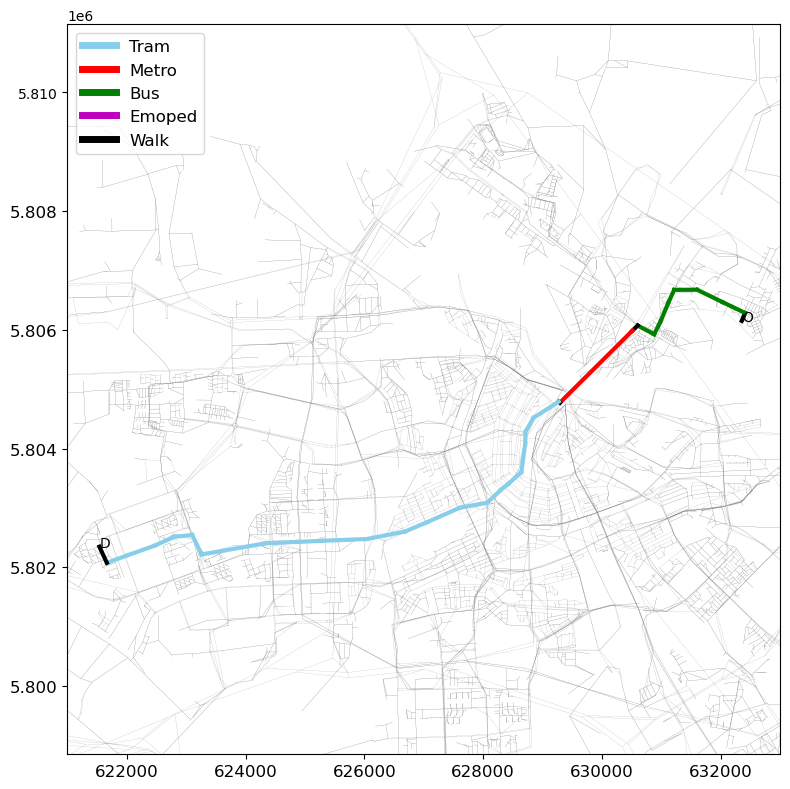

In [99]:
fig, ax = plt.subplots(figsize=(8, 8))

draw_roads(ax, mmgraph_pt.roads, color='grey', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)

# Params of the visualization
colors = {'BUS': 'green', 'METRO': 'red', 'TRAM': 'skyblue'}

#for layer in mmgraph_pt.layers.values():
#    if type(layer) == PublicTransportLayer:
#        for name, line in layer.lines.items():
#                draw_line(ax, mmgraph_pt, line, color=colors[name[:name.find('_')]], 
#                          linkwidth=0.4, nodesize=1, line_label=None, label_size=1, alpha=1., stopmarkeredgewidth=0.1)

#plt.plot(x_od, y_od, 'dk', alpha=0.4)

#plt.plot(x_st, y_st, '*g')

#plt.plot(x_nodes, y_nodes, '.m', alpha=0.5, markersize=1)

#plt.plot(list_pos_emoped[:,0], list_pos_emoped[:,1], ':.')

for i in range(1,len(pos_user)):
    if 'BUS' in path[i-1] and 'BUS' in path[i]:
        opt = 'green'
    elif 'TRAM' in path[i-1] and 'TRAM' in path[i]:
        opt = 'skyblue'
    elif 'METRO' in path[i-1] and 'METRO' in path[i]:
        opt = 'red'
    elif 'EMOPED' in path[i-1] and 'EMOPED' in path[i]:
        opt = 'm'
    else:
        opt = 'k'
    plt.plot(pos_user[i-1:i+1,0], pos_user[i-1:i+1,1], color=opt, linewidth=3)
plt.text(pos_user[0,0], pos_user[0,1], 'O')
plt.text(pos_user[-1,0], pos_user[-1,1], 'D')

#plt.hexbin(pos[:,0],pos[:,1], gridsize=20, cmap='Greens')

#plt.plot(pos[:,0],pos[:,1], 'k+')
#plt.plot(pos[:,0],pos[:,1]+600, 'x')

#plt.hexbin(o_pt_before[:,0],o_pt_before[:,1], gridsize=20, cmap='Purples')
#plt.hexbin(d_pt_before[:,0],d_pt_before[:,1], gridsize=20, cmap='Purples')
#plt.hexbin(o_pt_after[:,0],o_pt_after[:,1], gridsize=20, cmap='Purples')
#plt.hexbin(d_pt_after[:,0],d_pt_after[:,1], gridsize=20, cmap='Purples')

x=list(polygon[:,0])
x.append(polygon[0,0])
y=list(polygon[:,1])
y.append(polygon[0,1])
#plt.plot(x, y, '+--k')

#plt.plot(pos1[:,0],pos1[:,1], 'bo', alpha=0.9)
#plt.plot(pos2[:,0],pos2[:,1], 'g.', alpha=0.9)

#plt.plot(origin_points_far[:,0],origin_points_far[:,1], 'b+')
#plt.plot(destination_points[mask_o,0],destination_points[mask_o,1], 'bx')

#plt.plot(origin_points[mask_d,0],origin_points[mask_d,1], 'm+')
#plt.plot(destination_points_far[:,0],destination_points_far[:,1], 'mx')


legend = [Line2D([0, 1], [0, 1], color='skyblue', linewidth=5,
            label='Tram'),
          Line2D([0, 1], [0, 1], color='red', linewidth=5,
            label='Metro'),
          Line2D([0, 1], [0, 1], color='green', linewidth=5,
            label='Bus'),
          Line2D([0, 1], [0, 1], color='m', linewidth=5,
            label='Emoped'),
          Line2D([0, 1], [0, 1], color='k', linewidth=5,
            label='Walk')]
#          Line2D([0, 1], [0, 1], marker='*', markersize=10, color='b', linewidth=0,
#            label='Virtual station')]

legend = plt.legend(handles=legend, fontsize=FONT_SIZE_LEG)
#plt.legend(, ncol=2, loc='lower left', bbox_to_anchor=(0.1,1),)
plt.xticks(fontsize=FONT_SIZE_AXI)
plt.yticks(fontsize=FONT_SIZE_AXI)
#plt.xlim([617000,640000])
#plt.ylim([5.793e6, 5.813e6])
plt.xlim([621000,633000])
plt.ylim([5.802e6, 5.808e6])
plt.tight_layout() 
#plt.savefig(params['figdir']+'path_notcs_'+str(id)+'.pdf', bbox_inches = 'tight')

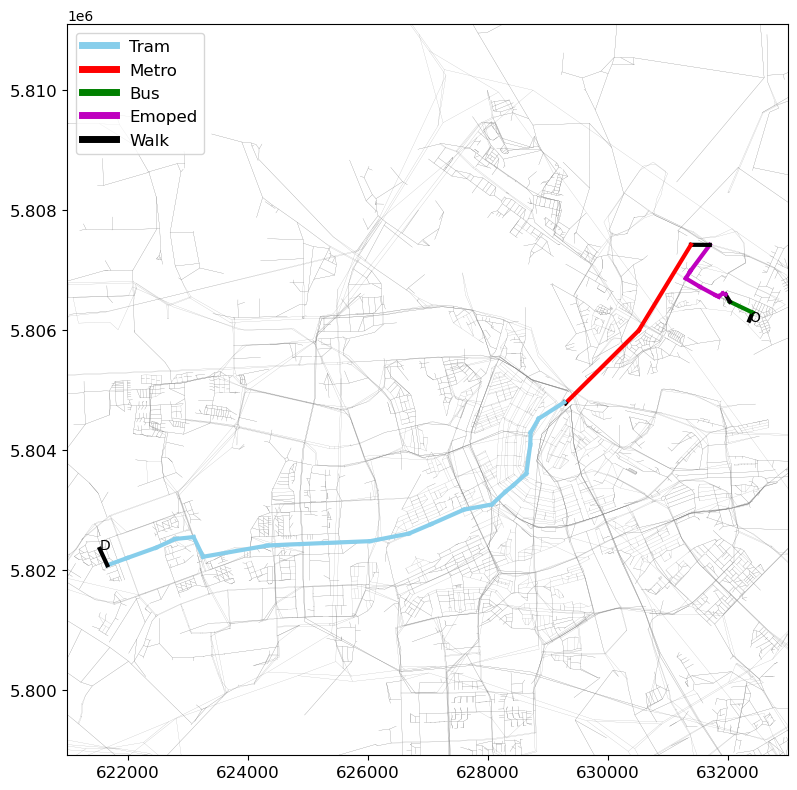

In [100]:
fig, ax = plt.subplots(figsize=(8, 8))

draw_roads(ax, mmgraph_pt.roads, color='grey', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)

# Params of the visualization
colors = {'BUS': 'green', 'METRO': 'red', 'TRAM': 'skyblue'}

for i in range(1,len(pos_user2)):
    if 'BUS' in path2[i-1] and 'BUS' in path2[i]:
        opt = 'green'
    elif 'TRAM' in path2[i-1] and 'TRAM' in path2[i]:
        opt = 'skyblue'
    elif 'METRO' in path2[i-1] and 'METRO' in path2[i]:
        opt = 'red'
    elif 'EMOPED' in path2[i-1] and 'EMOPED' in path2[i]:
        opt = 'm'
    else:
        opt = 'k'
    plt.plot(pos_user2[i-1:i+1,0], pos_user2[i-1:i+1,1], color=opt, linewidth=3)
plt.text(pos_user2[0,0], pos_user2[0,1], 'O')
plt.text(pos_user2[-1,0], pos_user2[-1,1], 'D')

legend = [Line2D([0, 1], [0, 1], color='skyblue', linewidth=5,
            label='Tram'),
          Line2D([0, 1], [0, 1], color='red', linewidth=5,
            label='Metro'),
          Line2D([0, 1], [0, 1], color='green', linewidth=5,
            label='Bus'),
          Line2D([0, 1], [0, 1], color='m', linewidth=5,
            label='Emoped'),
          Line2D([0, 1], [0, 1], color='k', linewidth=5,
            label='Walk')]
#          Line2D([0, 1], [0, 1], marker='*', markersize=10, color='b', linewidth=0,
#            label='Virtual station')]

legend = plt.legend(handles=legend, fontsize=FONT_SIZE_LEG)
plt.tight_layout() 
#plt.legend(, ncol=2, loc='lower left', bbox_to_anchor=(0.1,1),)
plt.xticks(fontsize=FONT_SIZE_AXI)
plt.yticks(fontsize=FONT_SIZE_AXI)
plt.xlim([617000,640000])
plt.ylim([5.793e6, 5.813e6])
plt.xlim([621000,633000])
plt.ylim([5.802e6, 5.808e6])
#plt.savefig(params['figdir']+'path_taxsub_'+str(id)+'.pdf', bbox_inches = 'tight')

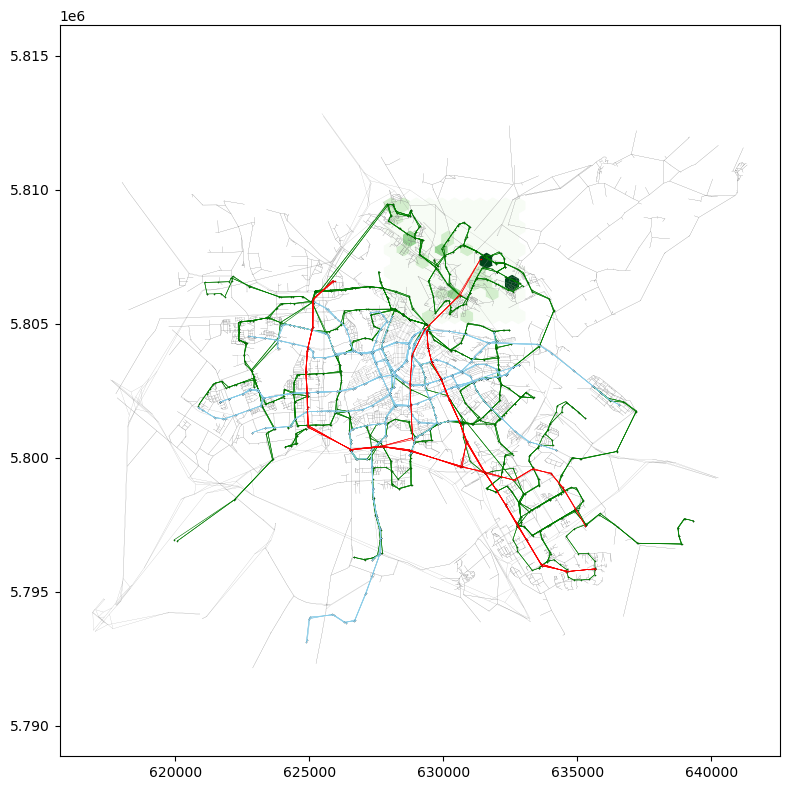

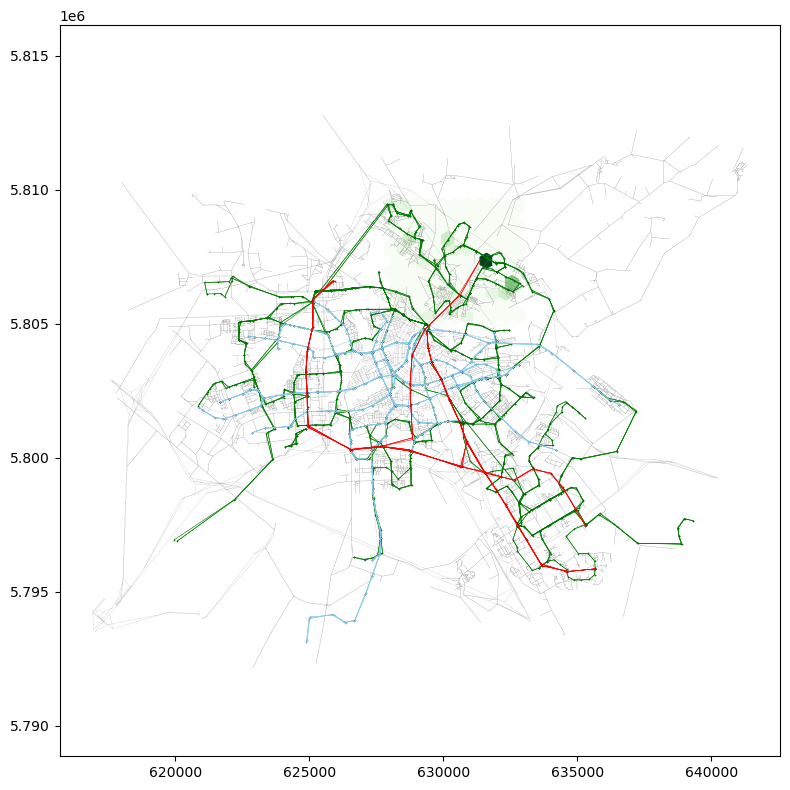

In [73]:
fig, ax = plt.subplots(figsize=(8, 8))
draw_roads(ax, mmgraph_pt.roads, color='grey', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)
for layer in mmgraph_pt.layers.values():
    if type(layer) == PublicTransportLayer:
        for name, line in layer.lines.items():
                draw_line(ax, mmgraph_pt, line, color=colors[name[:name.find('_')]], 
                          linkwidth=0.4, nodesize=1, line_label=None, label_size=1, alpha=1., stopmarkeredgewidth=0.1)
plt.hexbin(pos1[:,0],pos1[:,1], gridsize=10, cmap='Greens')

fig, ax = plt.subplots(figsize=(8, 8))
draw_roads(ax, mmgraph_pt.roads, color='grey', linkwidth=0.1, nodesize=0, draw_stops=False, node_label=False)
for layer in mmgraph_pt.layers.values():
    if type(layer) == PublicTransportLayer:
        for name, line in layer.lines.items():
                draw_line(ax, mmgraph_pt, line, color=colors[name[:name.find('_')]], 
                          linkwidth=0.4, nodesize=1, line_label=None, label_size=1, alpha=1., stopmarkeredgewidth=0.1)
plt.hexbin(pos2[:,0],pos2[:,1], gridsize=10, cmap='Greens')

## Station evolution

In [74]:
df_stations['position'] = df_stations.apply(lambda row: '%.3f %.3f'%(row.x_node, row.y_node), axis=1)

In [75]:
df_stations.position

0      628722.734 5807971.700
1      627015.180 5800282.299
2      632442.071 5803391.293
3      632373.539 5806132.351
4      628631.690 5804125.343
                ...          
561    628798.907 5801967.108
562    630590.828 5806094.726
563    631324.080 5807562.573
564    628746.292 5802722.373
565    628903.209 5800750.552
Name: position, Length: 566, dtype: object

In [76]:
station_emoped = np.zeros((len(df_stations), df_stations.nb_emoped.sum()))
nb_emoped_stations = np.zeros((len(df_emoped1_notax.TIME.unique()), len(df_stations)), int)
for i_t, t in enumerate(df_emoped1_notax.TIME.unique()):
    df = df_emoped1_notax[df_emoped1_notax.TIME==t]
    df2 = df[df.STATE=='STOP']
    for i,row in df2.iterrows():
        i_sta = df_stations.index[df_stations.position==row.POSITION][0]
        station_emoped[:, row.ID] = 0
        station_emoped[i_sta, row.ID] = 1
    df3 = df[df.STATE!='STOP']
    for i,row in df3.iterrows():
        station_emoped[:, row.ID] = 0
    nb_emoped_stations[i_t] = station_emoped.sum(axis=1)
    

In [77]:
#df_stations.index[df_stations.position==row.POSITION][0]

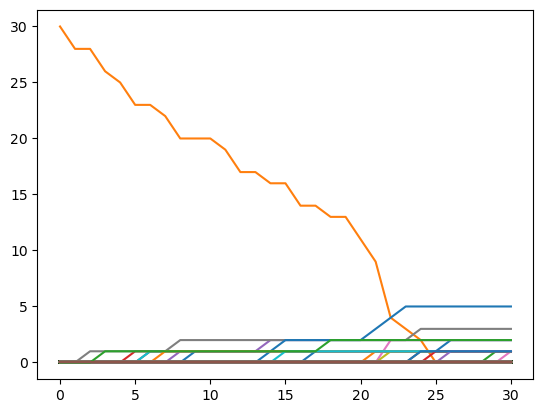

In [78]:
plt.plot(nb_emoped_stations);
#plt.ylim([0,5])

In [79]:
station_id = []
for pos_ in pos:
    station = df_stations.index[df_stations.position == '%.3f %.3f'%(pos_[0], pos_[1])]
    station_id.append(station)

In [80]:
station_id_unique = np.unique(station_id)

In [81]:
plt.plot(nb_emoped_stations[:,station_id_unique]);

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
station_id_unique

In [ ]:
net_length = 0
for name_sect in mmgraph_pt.roads.sections:
    sect = mmgraph_pt.roads.sections[name_sect]
    net_length += sect.length
print(net_length*1e-3)

In [ ]:
df_flow_notax_emoped = df_flow_notax[df_flow_notax.VEHICLE_TYPE=='BIKE']
df_flow_sub_emoped = df_flow_subsidy[df_flow_subsidy.VEHICLE_TYPE=='BIKE']

In [ ]:
plt.plot(df_flow_notax_emoped.ACCUMULATION)
plt.plot(df_flow_sub_emoped.ACCUMULATION)